# SARIMAX: Introduction
[Source](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html)

----------------------------------

This notebook replicates examples from the Stata ARIMA time series estimation and postestimation documentation.

First, we replicate the four estimation examples http://www.stata.com/manuals13/tsarima.pdf:

1. ARIMA(1,1,1) model on the U.S. Wholesale Price Index (WPI) dataset.
2. Variation of example 1 which adds an MA(4) term to the ARIMA(1,1,1) specification to allow for an additive seasonal effect.
3. ARIMA(2,1,0) x (1,1,0,12) model of monthly airline data. This example allows a multiplicative seasonal effect.
4. ARMA(1,1) model with exogenous regressors; describes consumption as an autoregressive process on which also the money supply is assumed to be an explanatory variable.

Second, we demonstrate postestimation capabilities to replicate http://www.stata.com/manuals13/tsarimapostestimation.pdf. The model from example 4 is used to demonstrate:

1. One-step-ahead in-sample prediction
2. n-step-ahead out-of-sample forecasting
3. n-step-ahead in-sample dynamic prediction

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

In [3]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10,3))
plt.rc("font", size=10)

# Reading the data

In [4]:
# Reading data
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data_origin = pd.read_stata(BytesIO(wpi1))
data_origin.head()

,wpi,t,ln_wpi
0,30.700001,1960-01-01,3.424263
1,30.799999,1960-04-01,3.427515
2,30.700001,1960-07-01,3.424263
3,30.700001,1960-10-01,3.424263
4,30.799999,1961-01-01,3.427515


In [5]:
# Reading data
data_origin = pd.read_stata('data/wpi1.dta')
data_origin.head()

,wpi,t,ln_wpi
0,30.700001,1960-01-01,3.424263
1,30.799999,1960-04-01,3.427515
2,30.700001,1960-07-01,3.424263
3,30.700001,1960-10-01,3.424263
4,30.799999,1961-01-01,3.427515


In [6]:
# Preparing the index
data_origin.set_index('t', inplace=True)

# Set the frequency
data_origin.index.freq="QS-OCT"

data_origin.head()

,wpi,ln_wpi
t,,
1960-01-01,30.700001,3.424263
1960-04-01,30.799999,3.427515
1960-07-01,30.700001,3.424263
1960-10-01,30.700001,3.424263
1961-01-01,30.799999,3.427515


In [7]:
data_origin.index

DatetimeIndex(['1960-01-01', '1960-04-01', '1960-07-01', '1960-10-01',
               '1961-01-01', '1961-04-01', '1961-07-01', '1961-10-01',
               '1962-01-01', '1962-04-01',
               ...
               '1988-07-01', '1988-10-01', '1989-01-01', '1989-04-01',
               '1989-07-01', '1989-10-01', '1990-01-01', '1990-04-01',
               '1990-07-01', '1990-10-01'],
              dtype='datetime64[ns]', name='t', length=124, freq='QS-OCT')

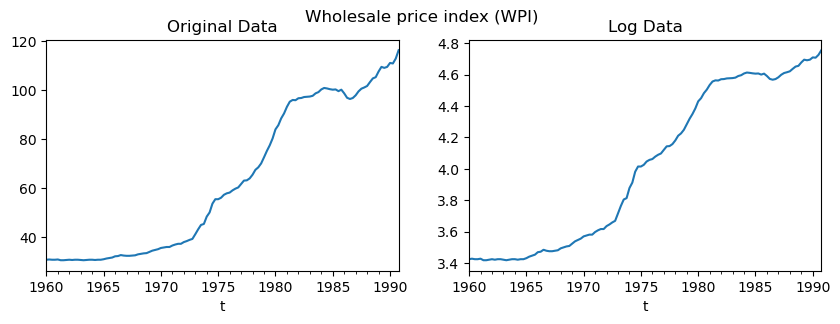

In [8]:
# Viewing the data
fig, (ax1, ax2) = plt.subplots(1, 2)
data_origin.wpi.plot(ax=ax1)
data_origin.ln_wpi.plot(ax=ax2)
ax1.set_title('Original Data')
ax2.set_title('Log Data')
fig.suptitle('Wholesale price index (WPI)')
plt.show()

# ARIMA Example 1: Arima
As can be seen in the graphs from Example 2, the Wholesale price index (WPI) is growing over time (i.e. is not stationary). Therefore an ARMA model is not a good specification. In this first example, we consider a model where the original time series is assumed to be integrated of order 1, so that the difference is assumed to be stationary, and fit a model with one autoregressive lag and one moving average lag, as well as an intercept term.

The postulated data process is then:
$$ \Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon y_{t-1} + \epsilon_t $$

where 
$ c $ is the intercept of the ARMA model, $ \Delta $ is the first-difference operator, and we assume $ \epsilon_t ~ N(0, \sigma^2) $. This can be rewritten to emphasize lag polynomials as (this will be useful in example 2, below):
$$ (1 - \phi_1 L) \Delta y_t = c + (1 + \theta_1 L)\epsilon_t $$

where $ L $ is the lag operator.

Notice that one difference between the Stata output and the output below is that Stata estimates the following model:
$$ (\delta y_t - \beta_0) = \phi_1 (\Delta y_{t-1} - \beta_0) + \theta_1\epsilon_{t-1} + \epsilon_t $$

where $ \beta_0 $ is the mean of the process $ y_t $. This model is equivalent to the one estimated in the statsmodels SARIMAX class, but the interpretation is different. To see the equivalence, note that:
$$ (\delta y_t - \beta_0) = \phi_1 (\Delta y_{t-1} - \beta_0) + \theta_1\epsilon_{t-1} + \epsilon_t $$
$$ \delta y_t = (1 - \phi_1)\beta_0 + \phi_1\Delta y_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t $$

so that $ c = (1 - \phi_1)\beta_0 $.

In [9]:
data = data_origin.copy()
data.head()

,wpi,ln_wpi
t,,
1960-01-01,30.700001,3.424263
1960-04-01,30.799999,3.427515
1960-07-01,30.700001,3.424263
1960-10-01,30.700001,3.424263
1961-01-01,30.799999,3.427515


In [10]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Sat, 01 Jul 2023   AIC                            278.703
Time:                        10:41:53   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

# ARIMA Example 2: Arima with additive seasonal effects
This model is an extension of that from example 1. Here the data is assumed to follow the process (Remember we have quarters):
$$ \Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon y_{t-1} + \theta_4 \epsilon y_{t-4} + \epsilon_t $$

The new part of this model is that there is allowed to be a annual seasonal effect (it is annual even though the periodicity is 4 because the dataset is quarterly). The second difference is that this model uses the log of the data rather than the level.

Before estimating the dataset, graphs showing:
* The time series (in logs)
* The first difference of the time series (in logs)
* The autocorrelation function
* The partial autocorrelation function.

From the first two graphs, we note that the original time series does not appear to be stationary, whereas the first-difference does. This supports either estimating an ARMA model on the first-difference of the data, or estimating an ARIMA model with 1 order of integration (recall that we are taking the latter approach). The last two graphs support the use of an ARMA(1,1,1) model.

In [11]:
data = data_origin.copy()
data.head()

,wpi,ln_wpi
t,,
1960-01-01,30.700001,3.424263
1960-04-01,30.799999,3.427515
1960-07-01,30.700001,3.424263
1960-10-01,30.700001,3.424263
1961-01-01,30.799999,3.427515


In [12]:
data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()
data.head()

,wpi,ln_wpi,D.ln_wpi
t,,,
1960-01-01,30.700001,3.424263,NaN
1960-04-01,30.799999,3.427515,0.003252
1960-07-01,30.700001,3.424263,-0.003252
1960-10-01,30.700001,3.424263,0.000000
1961-01-01,30.799999,3.427515,0.003252


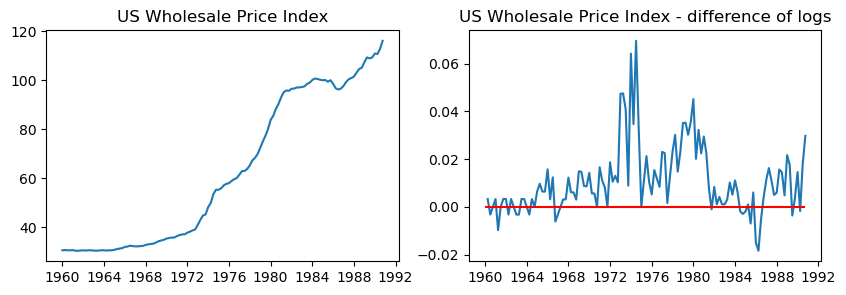

In [13]:
# Graph data
fig, (ax1, ax2) = plt.subplots(1, 2)

# Levels
ax1.plot(data.index._mpl_repr(), data['wpi'], '-')
ax1.set(title='US Wholesale Price Index')

# Log difference
ax2.plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
ax2.hlines(0, data.index[0], data.index[-1], 'r')
ax2.set(title='US Wholesale Price Index - difference of logs');

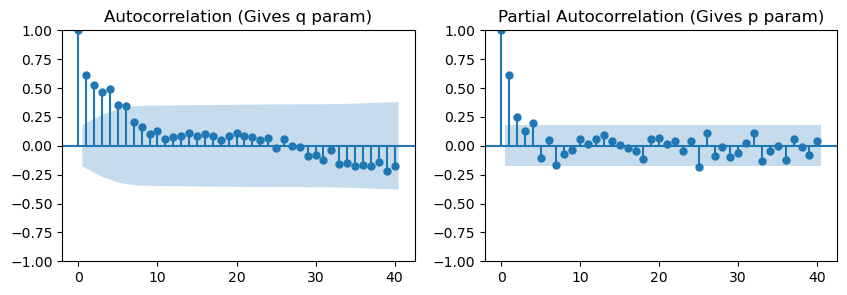

In [14]:
# Graph data
fig, (ax1, ax2) = plt.subplots(1, 2)

sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, method='ywm', ax=ax2)

ax1.set_title('Autocorrelation (Gives q param)')
ax2.set_title('Partial Autocorrelation (Gives p param)')
plt.show()

To understand how to specify this model in statsmodels, first recall that from example 1 we used the following code to specify the ARIMA(1,1,1) model:

In [15]:
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))

The order argument is a tuple of the form (AR specification (p param), Integration order (d param), MA specification (q param)). The integration order must be an integer (for example, here we assumed one order of integration, so it was specified as 1. In a pure ARMA model where the underlying data is already stationary, it would be 0).

For the AR specification and MA specification components, there are two possibilities. The first is to specify the maximum degree of the corresponding lag polynomial, in which case the component is an integer. For example, if we wanted to specify an ARIMA(p, d, q) = ARIMA(1,1,4) process, we would use:

In [16]:
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,4))

and the corresponding data process would be:
$$ \Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon y_{t-1} + \theta_2 \epsilon y_{t-2} + \theta_3 \epsilon y_{t-3} + \theta_4 \epsilon y_{t-4} + \epsilon_t $$
or
$$ (1 - \phi_1 L) \Delta y_t = c + (1 + \theta_1 L + \theta_2 L^2+ \theta_3 L^3 + \theta_4 L^4)\epsilon_t $$

When the specification parameter is given as a maximum degree of the lag polynomial, it implies that all polynomial terms up to that degree are included. Notice that this is not the model we want to use, because it would include terms for $ \epsilon_{t-2} $ and $ \epsilon_{t-3} $, which we do not want here.

What we want is a polynomial that has terms for the 1st and 4th degrees, but leaves out the 2nd and 3rd terms. To do that, we need to provide a tuple for the specification parameter, where the tuple describes the lag polynomial itself. In particular, here we would want to use:

In [17]:
ar = 1          # this is the maximum degree specification
ma = (1,0,0,1)  # this is the lag polynomial specification
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(ar,1,ma))

This gives the following form for the process of the data:
$$ \Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon y_{t-1} + \theta_4 \epsilon y_{t-4} + \epsilon_t $$
$$ (1 - \phi_1 L) \Delta y_t = c + (1 + \theta_1 L + \theta_4 L^4)\epsilon_t $$

which is what we want.

In [18]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['ln_wpi'], trend='c', order=(1,1,(1,0,0,1)))
res = mod.fit(disp=False)
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 386.033
Date:                   Sat, 01 Jul 2023   AIC                           -762.067
Time:                           10:41:54   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.355
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.483      0.138      -0.001       0.006
ar.L1          0.7810      0.094      8.275      0.000       0.596       0.966
ma.L1         -0.3994      0

# ARIMA Example 3: Airline Model

In the previous example, we included a seasonal effect in an additive way, meaning that we added a term allowing the process to depend on the 4th MA lag. It may be instead that we want to model a seasonal effect in a multiplicative way. We often write the model then as an ARIMA $ (p,d,q) \times (P,D,Q)_s $, where the lowercase letters indicate the specification for the non-seasonal component, and the uppercase letters indicate the specification for the seasonal component; 
$ s $ is the periodicity of the seasons (e.g. it is often 4 for quarterly data or 12 for monthly data). The data process can be written generically as:
$$ \phi_p(L) \tilde{\phi}p (L^s) \Delta^d\Delta_{s}^D y_t = A(t) + \theta_q(L) \tilde{\theta}_Q(L^s) \epsilon_t $$

where:
* $ \phi_p(L) $ is the non-seasonal autoregressive lag polynomial
* $ \tilde{\phi}p (L^s) $ is the seasonal autoregressive lag polynomial
* $ \Delta^d\Delta_{s}^D y_t $ is the time series, differenced $ d $ times, and seasonally differenced $ D $ times.
* $ A(t) $ is the trend polynomial (including the intercept)
* $ \theta_q(L) $ is the non-seasonal moving average lag polynomial
* $ \tilde{\theta}_Q(L^s) $ is the seasonal moving average lag polynomial

sometimes we rewrite this as:
$$ \phi_p(L) \tilde{\phi}p(L^s) y_{t}^* = A(t) + \theta_q(L) \tilde{\theta}_Q(L^s) \epsilon_t $$

where $  y_{t}^* = \Delta^d\Delta_{s}^D y_t $. This emphasizes that just as in the simple case, after we take differences (here both non-seasonal and seasonal) to make the data stationary, the resulting model is just an ARMA model.

As an example, consider the airline model ARIMA $ (2,1,0) \times (1,1,0)_12 $, with an intercept. The data process can be written in the form above as:
$$ (1 - \phi_1 L - \phi_2 L^2)(1 - \tilde{\phi}_1L^{12})\Delta\Delta_{12}y_t = c + \epsilon_t $$

Here, we have:
* $ \phi_p(L) = (1 - \phi_1 L - \phi_2 L^2) $ 
* $ \tilde{\phi}p(L^s) = (1 - \tilde{\phi}_1L^{12}) $
* $ d=1, D=1, s=12 $ indicating that $ y_{t}^* $ is derived from $ y_t $ by taking first-differences and then taking 12-th differences.
* $ A(t) $ is the constant trend polynomial (i.e. just an intercept)
* $ \theta_q(L) = \tilde{\theta}_Q(L^s) = 1 $ (i.e. there is no moving average effect)

It may still be confusing to see the two lag polynomials in front of the time-series variable, but notice that we can multiply the lag polynomials together to get the following model:
$$ (1 - \phi_1 L - \phi_2 L^2 - \tilde{\phi}_1L^{12} + \phi\tilde{\phi}_1L^{13} + \phi_2\tilde{\phi}_1L^{14})y_{t}^* = c + \epsilon_t $$

which can be rewritten as:
$$ y_{t}^* = c + \phi_1 y_{t-1}^* + \phi_2 y_{t-2}^* - \tilde{\phi}_1 y_{t-12}^* - \phi\tilde{\phi}_1 y_{t-13}^* - \phi_2\tilde{\phi}_1 y_{t-14}^* + \epsilon_t $$

This is similar to the additively seasonal model from example 2, but the coefficients in front of the autoregressive lags are actually combinations of the underlying seasonal and non-seasonal parameters.

Specifying the model in statsmodels is done simply by adding the **seasonal_order argument**, which accepts a tuple of the form **(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)**. The seasonal AR and MA specifications, as before, can be expressed as a maximum polynomial degree or as the lag polynomial itself. Seasonal periodicity is an integer.

For the airline model ARIMA $(2,1,0)\times(1,1,0)_12 $ with an intercept, the command is:

In [19]:
# Reading a new database
# air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
# data = pd.read_stata(BytesIO(air2))
airdf = pd.read_stata('data/air2.dta')
print(airdf.head())
airdf.index = pd.date_range(start=datetime(int(airdf.time[0]), 1, 1), 
                            periods=len(airdf), freq='MS')
airdf['lnair'] = np.log(airdf['air'])
airdf.head()

   air         time    t
0  112  1949.000000  1.0
1  118  1949.083374  2.0
2  132  1949.166626  3.0
3  129  1949.250000  4.0
4  121  1949.333374  5.0


,air,time,t,lnair
1949-01-01,112,1949.000000,1.0,4.718499
1949-02-01,118,1949.083374,2.0,4.770685
1949-03-01,132,1949.166626,3.0,4.882802
1949-04-01,129,1949.250000,4.0,4.859812
1949-05-01,121,1949.333374,5.0,4.795791


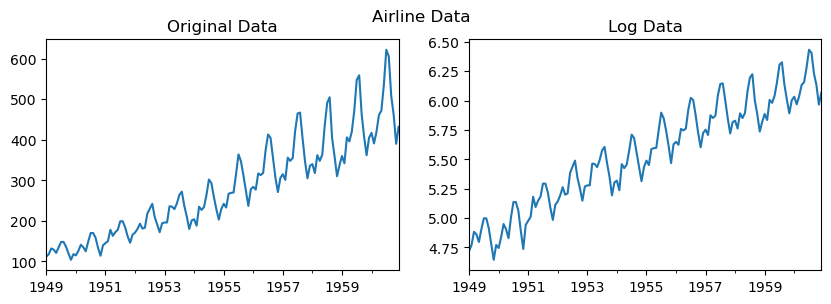

In [20]:
# Viewing the data
fig, (ax1, ax2) = plt.subplots(1, 2)
airdf.air.plot(ax=ax1)
airdf.lnair.plot(ax=ax2)
ax1.set_title('Original Data')
ax2.set_title('Log Data')
fig.suptitle('Airline Data')
plt.show()

In [21]:
mod = sm.tsa.statespace.SARIMAX(airdf['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12))

In [22]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(airdf['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12), 
                                simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       D.DS12.lnair   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 240.821
Date:                            Sat, 01 Jul 2023   AIC                           -473.643
Time:                                    10:41:54   BIC                           -462.142
Sample:                                02-01-1950   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.080     -5.045      0.000      -0.563      -0.248
ar.L2         -0.0799      0.099   

Notice that here we used an additional argument **simple_differencing=True**. This controls how the order of integration is handled in ARIMA models. If **simple_differencing=True**, then the time series provided as **endog** is literally differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata’s arima always uses simple differencing) or if the seasonal periodicity is large.

The default is **simple_differencing=False**, in which case the integration component is implemented as part of the state space formulation, and all of the original data can be used in estimation.

In [23]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(airdf['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12), 
                                simple_differencing=False)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              lnair   No. Observations:                  144
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 240.821
Date:                            Sat, 01 Jul 2023   AIC                           -473.643
Time:                                    10:41:54   BIC                           -462.142
Sample:                                01-01-1949   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4055      0.080     -5.042      0.000      -0.563      -0.248
ar.L2         -0.0797      0.099   

# ARIMA Example 4: ARMAX (Friedman)

This model demonstrates the use of explanatory variables (the X part of ARMAX). When exogenous regressors are included, the SARIMAX module uses the concept of “regression with SARIMA errors” (see http://robjhyndman.com/hyndsight/arimax/ for details of regression with ARIMA errors versus alternative specifications), so that the model is specified as:

$$ y_t = \beta_t x_t + u_t $$
$$ \phi_p(L) \tilde{\phi}p(L^s)\Delta^d\Delta_{s}^D u_t = A(t) + \theta(L)\tilde{\theta_Q}(L^s) \epsilon_t $$

Notice that the first equation is just a linear regression, and the second equation just describes the process followed by the error component as SARIMA (as was described in example 3). One reason for this specification is that the estimated parameters have their natural interpretations.

This specification nests many simpler specifications. For example, regression with AR(2) errors is:
$$ y_t = \beta_t x_t + u_t $$
$$ (1 - \phi_1L - \phi_2 L^2 ) u_t = A(t) + \epsilon_t $$

The model considered in this example is regression with ARMA(1,1) errors. The process is then written:
$$ {consump}_t = \beta_0 + \beta_1 {m2}_t + u_t $$
$$ (1 - \phi_1L) u_t = (1 - \theta_1 L)\epsilon_t $$

Notice that $ \beta_0 $ is, as described in example 1 above, not the same thing as an intercept specified by **trend='c'**. Whereas in the examples above we estimated the intercept of the model via the trend polynomial, here, we demonstrate how to estimate $ \beta_0 $ itself by adding a constant to the exogenous dataset. In the output, the $ \beta_0 $ is called $ const $, whereas above the intercept $ c $ was called $ intercept $ in the output.

In [24]:
# Reading a new database
# Dataset
# friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
# data = pd.read_stata(BytesIO(friedman2))
fried_data = pd.read_stata('data/friedman2.dta')
fried_data.index = fried_data.time
fried_data.index.freq = "QS-OCT"
fried_data.head()

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


In [25]:
fried_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 1946-01-01 to 1998-07-01
Freq: QS-OCT
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   m2       159 non-null    float32       
 1   time     211 non-null    datetime64[ns]
 2   m1       159 non-null    float32       
 3   consump  211 non-null    float32       
 4   pc92     207 non-null    float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 6.6 KB


In [26]:
fried_data.describe().T

,count,mean,std,min,25%,50%,75%,max
m2,159.0,1740.994507,1257.353149,289.149994,570.604980,1368.010010,2980.445068,4295.560059
m1,159.0,491.345276,341.444336,139.580002,198.714996,358.390015,780.074951,1150.760010
consump,211.0,1618.767334,1665.884644,134.899994,313.399994,759.900024,2707.849976,5843.000000
pc92,207.0,2565.942871,1232.208984,912.099976,1416.000000,2486.100098,3607.100098,5179.299805


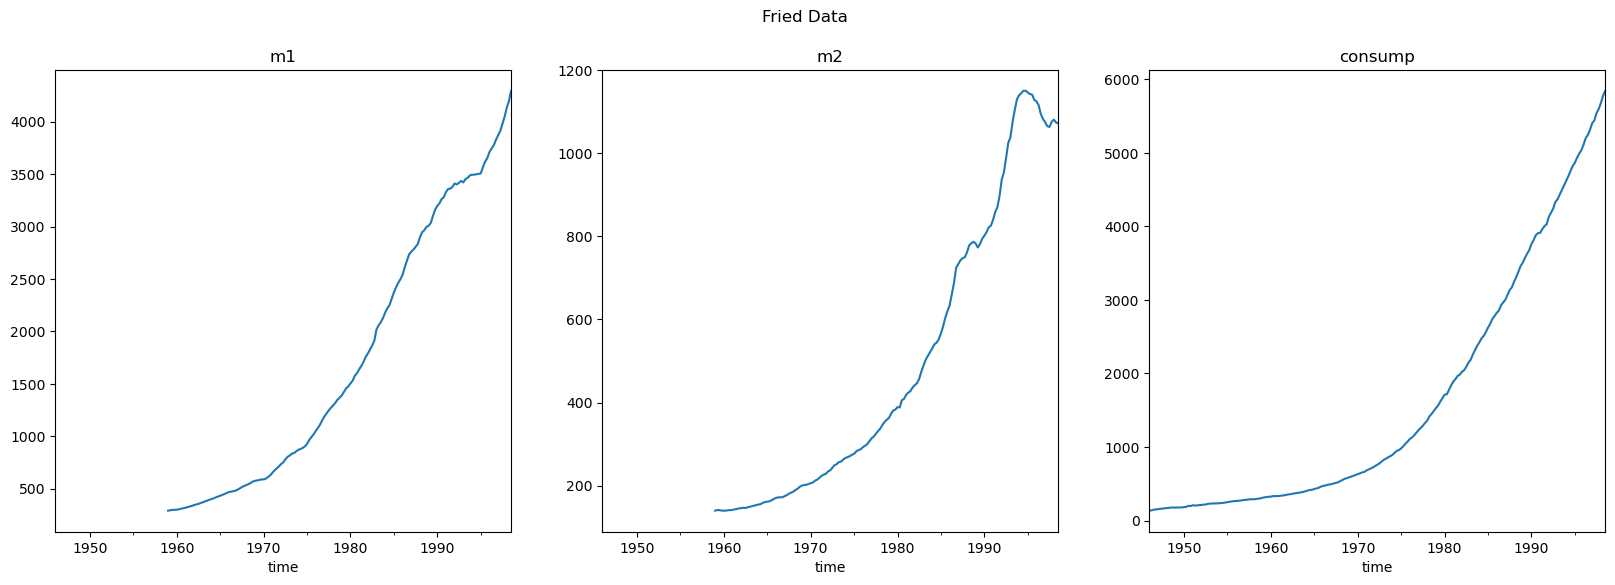

In [27]:
# Viewing the data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
fried_data.m2.plot(ax=ax1)
fried_data.m1.plot(ax=ax2)
fried_data.consump.plot(ax=ax3)
ax1.set_title('m1')
ax2.set_title('m2')
ax3.set_title('consump')
fig.suptitle('Fried Data')
plt.show()

In [28]:
# Variables
endog = fried_data.loc['1959':'1981', 'consump']
exog = sm.add_constant(fried_data.loc['1959':'1981', 'm2'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Sat, 01 Jul 2023   AIC                            691.015
Time:                        10:41:55   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0606     56.643     -0.637      0.524    -147.078      74.957
m2             1.1220      0.036     30.824      0.000       1.051       1.193
ar.L1          0.9348      0.041     22.717      0.0

# ARIMA Postestimation: Example 1 - Dynamic Forecasting¶
Here we describe some of the post-estimation capabilities of statsmodels’ SARIMAX.

First, using the model from example, we estimate the parameters using data that excludes the last few observations (this is a little artificial as an example, but it allows considering performance of out-of-sample forecasting and facilitates comparison to Stata’s documentation).

In [29]:
# Reading a new database
# Dataset
# friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
# data = pd.read_stata(BytesIO(friedman2))
raw = pd.read_stata('data/friedman2.dta')
raw.index = raw.time
raw.index.freq = "QS-OCT"
fried_data = raw.loc[:'1981']

In [30]:
raw

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976
...,...,...,...,...,...
1997-07-01,3979.270020,1997-07-01,1063.550049,5540.299805,4947.000000
1997-10-01,4046.389893,1997-10-01,1076.040039,5593.200195,4981.000000
1998-01-01,4133.879883,1998-01-01,1081.109985,5676.500000,5055.100098


In [31]:
fried_data

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976
...,...,...,...,...,...
1980-10-01,1601.099976,1980-10-01,408.920013,1836.800049,3034.199951
1981-01-01,1638.000000,1981-01-01,418.920013,1890.300049,3045.600098
1981-04-01,1670.550049,1981-04-01,423.899994,1923.500000,3045.800049


In [32]:
# Variables
endog = fried_data.loc['1959':, 'consump']
exog = sm.add_constant(fried_data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], 
                                order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -243.316
Date:                Sat, 01 Jul 2023   AIC                            496.633
Time:                        10:41:55   BIC                            508.352
Sample:                    01-01-1959   HQIC                           501.320
                         - 01-01-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6780     18.492      0.037      0.971     -35.565      36.921
m2             1.0379      0.021     50.329      0.000       0.997       1.078
ar.L1          0.8775      0.059     14.859      0.0

Next, we want to get results for the full dataset but using the estimated parameters (on a subset of the data).

In [33]:
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
res = mod.filter(fit_res.params)
print(fit_res.params)

const      0.678017
m2         1.037879
ar.L1      0.877543
ma.L1      0.277095
sigma2    31.697810
dtype: float64


The predict command is first applied here to get in-sample predictions. We use the full_results=True argument to allow us to calculate confidence intervals (the default output of predict is just the predicted values).

With no other arguments, predict returns the one-step-ahead in-sample predictions for the entire sample.

In [34]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
print(predict.predicted_mean)
# print(predict.row_labels)
# print(predict.se_mean)
# print(predict.tvalues)
# print(predict.var_pred_mean)
predict_ci

time
1959-01-01     300.780595
1959-04-01     314.699701
1959-07-01     318.333786
1959-10-01     322.140566
1960-01-01     324.148867
                 ...     
1980-10-01    1792.130797
1981-01-01    1866.122122
1981-04-01    1907.567707
1981-07-01    1944.034131
1981-10-01    1999.784134
Freq: QS-OCT, Name: predicted_mean, Length: 92, dtype: float64


,lower consump,upper consump
time,,
1959-01-01,272.008509,329.552680
1959-04-01,303.309353,326.090050
1959-07-01,307.273023,329.394548
1959-10-01,311.103821,333.177312
1960-01-01,313.113959,335.183776
...,...,...
1980-10-01,1781.096041,1803.165553
1981-01-01,1855.087367,1877.156878
1981-04-01,1896.532951,1918.602463


We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

The dynamic argument is specified to be an offset relative to the start argument. If start is not specified, it is assumed to be 0.

Here we perform dynamic prediction starting in the first quarter of 1978.

In [35]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='1978-01-01')
predict_dy_ci = predict_dy.conf_int()
# print(predict_dy.predicted_mean)
predict_dy_ci

,lower consump,upper consump
time,,
1959-01-01,272.008509,329.552680
1959-04-01,303.309353,326.090050
1959-07-01,307.273023,329.394548
1959-10-01,311.103821,333.177312
1960-01-01,313.113959,335.183776
...,...,...
1980-10-01,1636.739379,1692.880373
1981-01-01,1674.582271,1731.048967
1981-04-01,1707.984253,1764.700492


We can graph the one-step-ahead and dynamic predictions (and the corresponding confidence intervals) to see their relative performance. Notice that up to the point where dynamic prediction begins (1978:Q1), the two are the same.

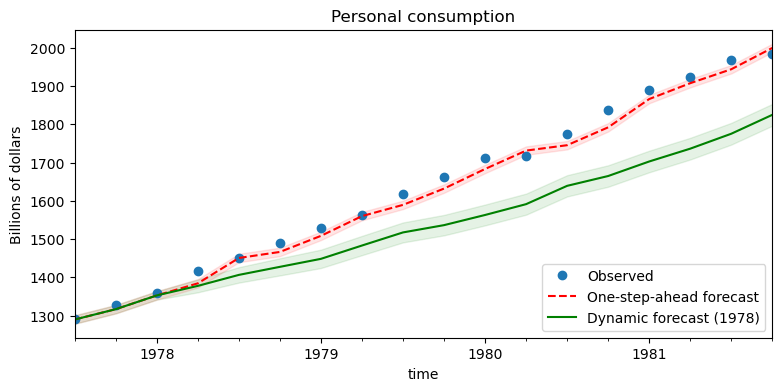

In [36]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
fried_data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', 
                                               label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', 
                                                  label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

Finally, graph the prediction error. It is obvious that, as one would suspect, one-step-ahead prediction is considerably better.

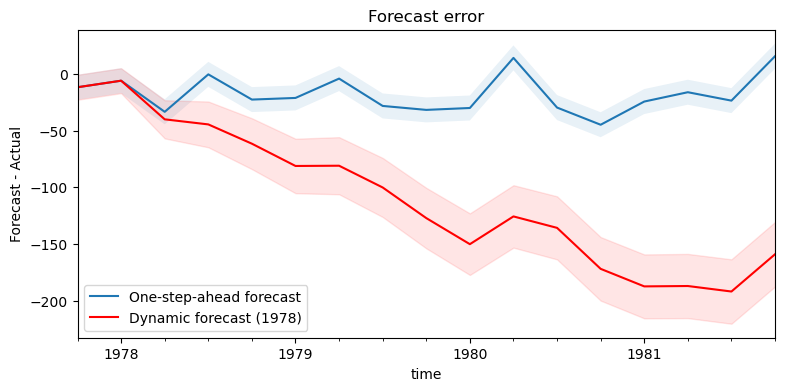

In [37]:
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - endog
predict_error.loc['1977-10-01':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc['1977-10-01':].copy()
ci.iloc[:,0] -= endog.loc['1977-10-01':]
ci.iloc[:,1] -= endog.loc['1977-10-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - endog
predict_dy_error.loc['1977-10-01':].plot(ax=ax, style='r', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-10-01':].copy()
ci.iloc[:,0] -= endog.loc['1977-10-01':]
ci.iloc[:,1] -= endog.loc['1977-10-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

----------------------------------